In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import meshio
import os
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow import keras

warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf


# Loading Dataset

In [3]:
x = np.arange(0.006, 0.0135, (0.0135-0.006)/300)
y = np.arange(0, 0.0025, 0.0025/75)

data_path = './Data'
path_sep = '\\' # use '/' for Unix and '\\' for Windows
folders = os.listdir(data_path)
        
subfolder = []
path = []
names = []
condition = []

for i in folders:
    if os.path.isdir(data_path + path_sep + i): 
        subfolder.append(data_path + path_sep + i)

for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for i in files:
        ext = os.path.splitext(i)
        if (ext[-1].lower() == '.vtk') & (ext[0][-2] != '_'):
            names.append(ext[0])
            string = ext[0].replace('ER', '').replace('Tin', '').replace('Uin', '').replace('Twall', '').split('_')[0:4]
            var = []
            for j in string:
                if j == 'Adiabatic':
                    var.append(0.)
                else:
                    var.append(float(j))
            condition.append(var)

Q_list = []
for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for counter,file in enumerate(files):
        mesh = meshio.read(folder+ path_sep +file)
        points = mesh.points
        Qdot = mesh.point_data['Qdot']
        boolArr = (points[:,1] == 0) & (points[:,0] >= 0.006)  
        Qdot = Qdot[boolArr]
        points = points[boolArr]
        old_points = points[:,[0, 2]]
        grid_x, grid_y = np.meshgrid(x, y)
        grid_new = griddata(old_points, Qdot, (grid_x, grid_y), method='nearest')
        Q_list.append(grid_new)
# Q_list

# Data Preparation

In [4]:
Qdot = np.array(Q_list)
Qdot = Qdot / np.max(Qdot)
mean = Qdot.mean(axis = 0)
Qdot = np.reshape(Qdot, (-1, 75, 300, 1))

normaliser = []
conditions = np.array(condition)
df = np.zeros(conditions.shape)
for i in range(conditions.shape[1]):
    df[:,i] = conditions[:,i] / np.max(conditions[:,i])
    normaliser.append(np.max(conditions[:,i]))

train_data, test_data, label_train, label_test = train_test_split(Qdot, df, test_size = 0.15)
print(Qdot.shape)
print(df.shape)

# Manual train test split if needed
#test_index = 

#train_index = 

#test_data = Qdot[test_index]
#train_data = Qdot[train_index]
#label_train = df[train_index]
#label_test = df[test_index]

(239, 75, 300, 1)
(239, 4)


In [5]:
print(normaliser)
# df
# Equivalence ratio (1)
# Temperature (460)
# Velocity (0.50 m/s)
# Wall Temperature (373 or None)

[1000.0, 460.0, 50.0, 373.0]


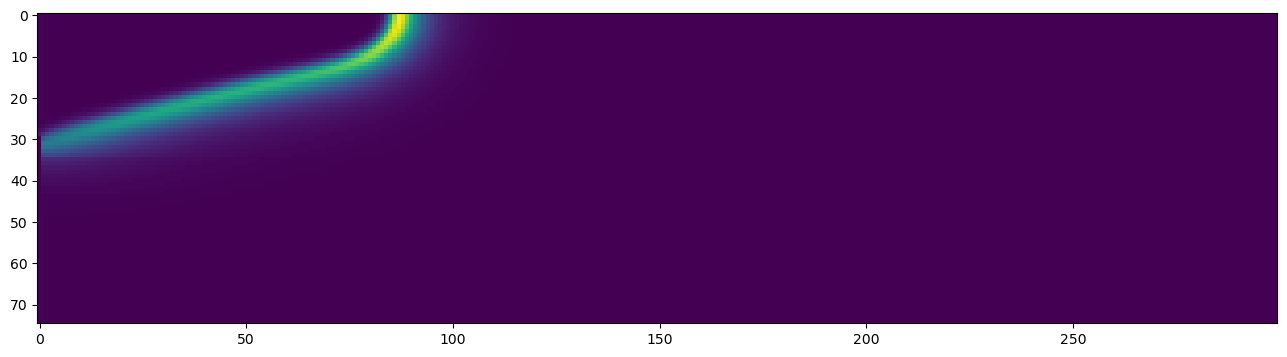

In [6]:
fig = plt.figure(figsize=(16, 80))
plt.imshow(np.reshape(Qdot[3],(75, 300)))
# plt.axis('off')

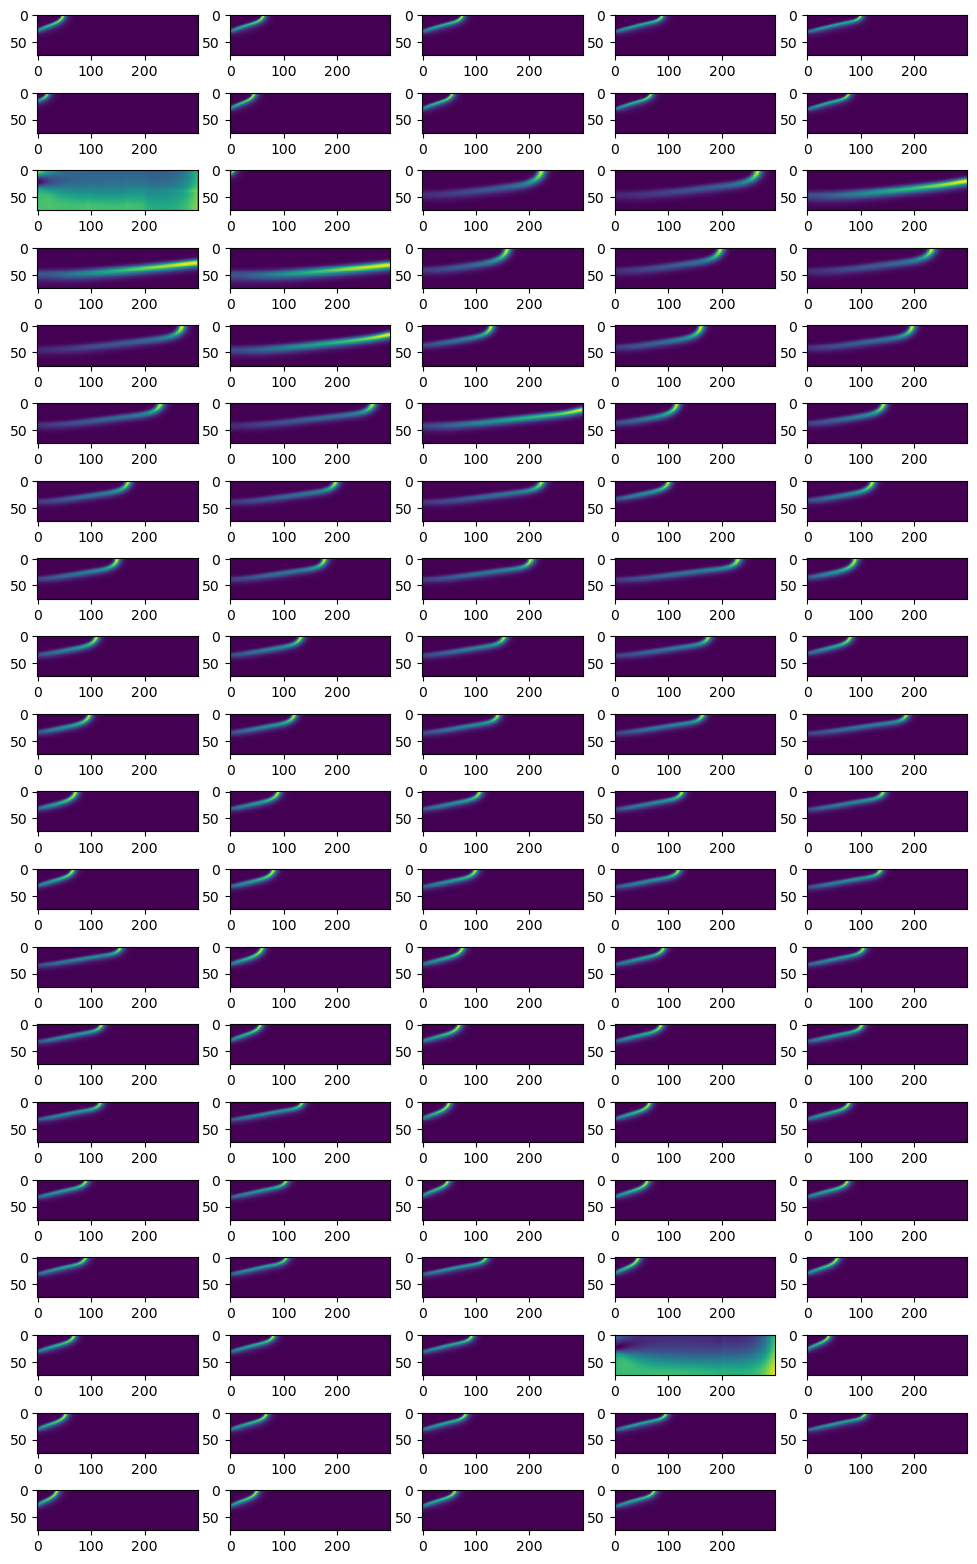

In [7]:
fig = plt.figure(figsize=(12, 20))
columns = 5
rows = 20

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Get the outlier out(TODO)

## Convolutional Autoencoder 

In [ ]:
# class CVAE(tf.keras.Model):
#   """Convolutional autoencoder."""

#   def __init__(self, latent_dim):
#     super(CVAE, self).__init__()
#     self.latent_dim = latent_dim
#     self.encoder = tf.keras.Sequential(
#         [
#             # Input layer 75x300x1
#             tf.keras.layers.InputLayer(input_shape=(75, 300, 1)),
            
#             # Conv layer 75x300x1 --> 75x150x32 --> 75x75x32
#             tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,2), 
#                                    padding='same', name='conv_1'),
#             tf.keras.layers.BatchNormalization(name='bn_1'),
#             tf.keras.layers.LeakyReLU(name='lrelu_1'),
#             tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='maxpool_1'),

#             # Conv layer 75x75x32 --> 36x36x64 --> 18x18x64
#             tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2),
#                                    name='conv_2'),
#             tf.keras.layers.BatchNormalization(name='bn_2'),
#             tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'),
            
#             # Conv layer 18x18x64 --> 9x9x64
#             tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
#                                    padding='same', name='conv_3'),
#             tf.keras.layers.BatchNormalization(name='bn_3'),

#             # Flatten  9x9x64
#             tf.keras.layers.Flatten(),
            
#             # Fully NN --> Laten variables
#             tf.keras.layers.Dense(latent_dim + latent_dim), 
#         ]
#     )

#     self.decoder = tf.keras.Sequential(
#         [
#             tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            
#             # Fully NN 9x9x64
#             tf.keras.layers.Dense(units = 9*9*64, activation='relu'),
#             tf.keras.layers.Reshape(target_shape = (9,9,64)),
            
#             # Conv layer 9x9x64 --> 18x18x64
#             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
#                                             padding='same', name='conv_4'),
#             tf.keras.layers.BatchNormalization(name='bn_4'),
            
#             # Conv layer 18x18x64 --> 36x36x64
#             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
#                                             activation='relu', name='conv_5'),
#             tf.keras.layers.BatchNormalization(name='bn_5'),
            
#             # Conv layer 36x36x64 --> 
#             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1, 2), padding='same',
#                                         activation='relu', name='conv_6'),
#             tf.keras.layers.BatchNormalization(name='bn_6'),
            
#             # Conv layer 75x150x32 --> 75x300x1
#             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',
#                                         activation='relu', name='conv_6')

#         ]
#     )

#   @tf.function
#   def sample(self, eps=None):
#     if eps is None:
#       eps = tf.random.normal(shape=(100, self.latent_dim))
#     return self.decode(eps, apply_sigmoid=True)

#   def encode(self, x):
#     mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
#     return mean, logvar

#   def reparameterize(self, mean, logvar):
#     eps = tf.random.normal(shape=mean.shape)
#     return eps * tf.exp(logvar * .5) + mean

#   def decode(self, z, apply_sigmoid=False):
#     logits = self.decoder(z)
#     if apply_sigmoid:
#       probs = tf.sigmoid(logits)
#       return probs
#     return logits

## Convolutional Autoencoder
### Encoder Part

In [9]:
input_encoder = (75,300,1)
input_decoder = (8,)

In [10]:
# def encoder(input_encoder):
model = tf.keras.Sequential([
    # Input layer 
    tf.keras.Input(shape= input_encoder, name='input_layer'),
    
    # Conv layer 
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1,2), 
                            padding='same', name='conv_1'),
    tf.keras.layers.BatchNormalization(name='bn_1'),
    tf.keras.layers.LeakyReLU(name='lrelu_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2), name='maxpool_1'),

    # Conv layer 
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2),
                            padding='same', name='conv_2'),
    tf.keras.layers.BatchNormalization(name='bn_2'),
    tf.keras.layers.LeakyReLU(name='lrelu_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'),
    
    # # Conv layer 
    # tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
    #                         padding='same', name='conv_3'),
    # tf.keras.layers.BatchNormalization(name='bn_3'),
    # tf.keras.layers.LeakyReLU(name='lrelu_3'),


    # Flatten  
    tf.keras.layers.Flatten(),
    
    # Fully NN --> Laten variables
    tf.keras.layers.Dense(8, name='dense_1')
], name='Encoder')
print(model.summary())
#     return model

# enc = encoder(input_encoder)



Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 75, 150, 32)       320       
                                                                 
 bn_1 (BatchNormalization)   (None, 75, 150, 32)       128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 75, 150, 32)       0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 38, 38, 64)        18496     
                                                                 
 bn_2 (BatchNormalization)   (None, 38, 38, 64)        256       
                                                                 
 lrelu_2 (LeakyReLU)         (None, 38, 38, 64)        0 

### Decoder Part

In [11]:
# def decoder(input_decoder):
model = tf.keras.Sequential([
            tf.keras.Input(shape=input_decoder),
            
            # Fully NN 9x9x64
            tf.keras.layers.Dense(units = 19*19*64, name='dense_1'),
            tf.keras.layers.Reshape(target_shape = (19,19,64)),
            
            # Conv layer 
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1, 2), 
                                            padding='same', name='conv_tr_1'),
            tf.keras.layers.BatchNormalization(name='bn_1'),
            tf.keras.layers.LeakyReLU(name='lrelu_1'),
            
            # Conv layer  
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1, 2),
                                            padding='same', name='conv_tr_2'),
            tf.keras.layers.BatchNormalization(name='bn_2'),
            tf.keras.layers.LeakyReLU(name='lrelu_2'),
            
            # Conv layer 
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), 
                                            padding='same', name='conv_tr_3'),
            tf.keras.layers.BatchNormalization(name='bn_3'),
            tf.keras.layers.LeakyReLU(name='lrelu_3'),
            
            # Conv layer 
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(2, 2), 
                                            padding='same', name='conv_tr_4'),
            tf.keras.layers.BatchNormalization(name='bn_4'),
            tf.keras.layers.LeakyReLU(name='lrelu_4')          
            
            # # Conv layer 
            # tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(1, 2), 
            #                                 padding='same', name='conv_tr_5'),
            # tf.keras.layers.BatchNormalization(name='bn_5'),
            # tf.keras.layers.LeakyReLU(name='lrelu_5'),           
                               
            
    ], name='Decoder')
model.summary()
    # return model

# enc = encoder(input_encoder)

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 23104)             207936    
                                                                 
 reshape (Reshape)           (None, 19, 19, 64)        0         
                                                                 
 conv_tr_1 (Conv2DTranspose  (None, 19, 38, 64)        36928     
 )                                                               
                                                                 
 bn_1 (BatchNormalization)   (None, 19, 38, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 19, 38, 64)        0         
                                                                 
 conv_tr_2 (Conv2DTranspose  (None, 19, 76, 32)        18464     
 )                                                         